# **SDGym - Synthetic Data Gym Training**

**Synthetic Data Gym** (SDGym) is a framework to benchmark the performance of synthetic data generators based on SDV and SDMetrics:

*   Learn a tabular model to synthesize rows in a table
*   Learn a relational data model to synthesize multiple, related tables
*   Learn a time-series model to synthesize new events

GitHub Link: https://github.com/sdv-dev/SDGym

A **Synthetic Data Generator** is a Python function (or method) that takes as input some data, which we call the real data, learns a model from it, and outputs new synthetic data that has the same structure and similar mathematical properties as the real one.

In [ ]:
import os
import sys
import platform
OS = platform.system()   # Operating System                                                             # returns 'Windows', 'Linux', etc

#**Platform Settings**

In [ ]:
colab_active = 'google.colab' in sys.modules
print("Colab Active: ", colab_active)
# Operating System
OS = platform.system()                           # returns 'Windows', 'Linux', etc

Colab Active:  True


# **Libraries Installation Section**

Installation of all required libraries: SDGym, gdown, pandas

In [ ]:
os.system('pip install --upgrade --no-cache-dir gdown')
os.system('pip install sdgym')
os.system('pip install pandas')
os.system('pip install matplotlib==3.1.3')

0

In [ ]:
!pip install pandas==1.3.4

     |████████████████████████████████| 11.3 MB 4.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
copulas 0.6.1 requires matplotlib<4,>=3.4.0; python_version >= "3.7", but you have matplotlib 3.1.3 which is incompatible.


# **All Imports**

In [ ]:
import timeit
import numpy as np
import pandas as pd
from sdv.demo import load_tabular_demo
from sdv.tabular import GaussianCopula, CTGAN, CopulaGAN
from sdv.evaluation import evaluate
from sdv.metrics.tabular import CSTest, KSTest                                      # Statistical Metrics
from sdv.metrics.tabular import BNLikelihood, BNLogLikelihood, GMLogLikelihood      # Likelihood Metrics¶
from sdv.metrics.tabular import LogisticDetection, SVCDetection                     # Detection Metrics
from sdv.metrics.tabular import MulticlassDecisionTreeClassifier                    # Machine Learning Efficacy Metrics¶
from sdv.metrics.tabular import NumericalLR                                         # Privacy Metrics

# **All Globals**

In [ ]:
benchmark = False
gaussian_copula_synth_model = False 
ctgan_synth_model = False
copula_gan_synth_model = True
dataset = 'telephony'   # satgpa, acs, telephony
model_to_test = "telephony_copulagan_1000_epochs.pkl"
#model_to_test = "telephony_copulagan_3_epochs.pkl"
model_names = []
limit_to_generate = 1000  # or None
training = False
save_score = True

#**All Hyper-parameters**

In [ ]:
epochs = 3

# **All Settings**

In [ ]:
start_global_time = timeit.default_timer()
pd.set_option('display.max_columns', 500) 
pd.set_option('display.max_rows', 500) 
if ctgan_synth_model == True and copula_gan_synth_model == True: # Only one Gan 
  ctgan_synth_model = False

#**Mounting Google Drive via Code**

In [ ]:
if colab_active is True: 
  from google.colab import drive
  drive.mount('/content/drive')
  sys.path.append('/content/drive/My Drive')
  model_path = "/content/drive/MyDrive/DL_Models/"
  if os.path.isdir(model_path) is False: 
    os.makedirs(model_path) 
else: 
  model_path = "./"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **All Functions Definitions**

In [ ]:
def explore_data(data): 
  print("\nHead of Data: \n", data.head())
  print("\nTail of Data: \n", data.tail())
  print("\nShape of Data: ", data.shape)
  print("\nInformation about Data: \n")
  try: 
    data.info()
  except: 
    pass
  print("\nTypes of Data attributes: \n")
  try: 
    data.dtypes
  except: 
    pass
  print("\nSummary of all numerical fields in the dataset: \n")
  try: 
    data.describe(include = [np.number])
  except: 
    pass
  print("\nSummary of all categorical fields in the dataset: \n")
  try: 
    data.describe(include = ['O'])
  except: 
    pass
  print("\nLoop Through Each Column and Check for nulls: \n")
  try: 
    for i in range(len(data.columns)):
        print(data.columns[i] + ": " + str(data[data.columns[i]].isna().sum()))
  except: 
    pass

def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
    return True
  else: 
    return None

# **Data Download - ACS, SatGPA, Telephony**

In [ ]:
if benchmark == True: 
  data = load_tabular_demo('student_placements')
  n_to_generate = data.shape[0]
else: 
  if dataset is 'satgpa':
    out = data_download("./satgpa.csv", "1NNVF1LhBDkW_KKp5_QW8cAiQDFatzWMy", OS, False)
    data = pd.read_csv('./satgpa.csv')
    data = data.drop(['sat_sum'], axis=1)
    data.to_csv('satgpa_no_sum.csv', sep=',')
    n_to_generate = data.shape[0]
  elif dataset is 'acs':
    out = data_download("./acs_dataset.zip", "1mKZfDieGBJP-cS-R7_i3zVKVawXThfUc", OS)
    if limit_to_generate is not None: 
      data = pd.read_csv('./acs_dataset.csv', nrows = limit_to_generate)
      n_to_generate = limit_to_generate
    else: 
      data = pd.read_csv('./acs_dataset.csv')
      n_to_generate = data.shape[0]
  elif dataset is 'telephony':
    out = data_download("./syntetic_telephony.zip", "1knlC9DQ-iQhxwpmd9qzFWSS0OcgI9-LA", OS)
    xl_file = pd.ExcelFile('./syntetic_telephony.xlsx')
    dfs = {sheet_name: xl_file.parse(sheet_name) for sheet_name in xl_file.sheet_names}
    data = dfs['Sheet1']
    n_to_generate = data.shape[0]

#**Data Preparation**

In [ ]:
if dataset is 'telephony':
  data.COD_CELLA_CHIAMATA=data.COD_CELLA_CHIAMATA.astype("int64").astype("str")

  data.DATA_CHIAMATA=pd.to_datetime(data.DATA_CHIAMATA, format='%Y%m%d')
  data.CHIAVE_NUM_CHIAMANTE=data.CHIAVE_NUM_CHIAMANTE.astype("int64").astype("str")
  
  data.ORA_MIN_CHIAMATA=data.ORA_MIN_CHIAMATA.astype("str").str.pad(width=6, side='left', fillchar='0')
  data.ORA_MIN_CHIAMATA =pd.to_datetime(data.ORA_MIN_CHIAMATA , format='%H%M%S')


#**Categorical Data Adjustment**

In [ ]:
if dataset is 'telephony':
  data["COD_CELLA_CHIAMATA"]="F"+data.COD_CELLA_CHIAMATA
  data["CHIAVE_NUM_CHIAMANTE"]="F"+data.CHIAVE_NUM_CHIAMANTE

# **Exploratory Analysis**

In [ ]:
explore_data(data)


Head of Data: 
   CHIAVE_NUM_CHIAMANTE DATA_CHIAMATA    ORA_MIN_CHIAMATA COD_CELLA_CHIAMATA
0   F14615194667453690    2017-01-22 1900-01-01 15:49:53                 F0
1   F14615194667453690    2017-01-29 1900-01-01 12:40:34                 F1
2   F14615194667453690    2017-01-29 1900-01-01 12:41:19                 F1
3   F14615194667453690    2017-01-22 1900-01-01 15:51:02                 F1
4   F14615194667453690    2017-01-22 1900-01-01 15:51:38                 F1

Tail of Data: 
      CHIAVE_NUM_CHIAMANTE DATA_CHIAMATA    ORA_MIN_CHIAMATA COD_CELLA_CHIAMATA
9995   F14615368752090240    2017-01-12 1900-01-01 12:09:10               F272
9996   F14615368752090240    2017-02-12 1900-01-01 18:26:01               F272
9997    F1508338528891430    2017-01-04 1900-01-01 09:26:27               F272
9998   F14615368752090240    2017-02-10 1900-01-01 15:11:58               F272
9999   F14615337422429130    2017-01-30 1900-01-01 09:09:03               F272

Shape of Data:  (10000, 4)

Informa

# **Synthetic Data Generation via Gaussian Copula Method**

In mathematical terms, a copula is a distribution over the unit cube [0,1]d which is constructed from a multivariate normal distribution over Rd by using the probability integral transform. Intuitively, a copula is a mathematical function that allows us to describe the joint distribution of multiple random variables by analyzing the dependencies between their marginal distributions.

In [ ]:
if gaussian_copula_synth_model == True:
  model = GaussianCopula()

  if training is True:
    model.fit(data)
    model_names.append(model_path+dataset+'_gaussian_copula_'+str(epochs)+'_epochs.pkl')
    model.save(model_names[-1])

# **Synthetic Data Generation via Conditional GAN**

Modeling the probability distribution of rows in tabular data and generating realistic synthetic data is a non-trivial task. Tabular data usually contains a mix of discrete and continuous columns. Continuous columns may have multiple modes whereas discrete columns are sometimes imbalanced making the modeling difficult. Existing statistical and deep neural network models fail to properly model this type of data. We design TGAN, which uses a conditional generative adversarial network to address these challenges. To aid in a fair and thorough comparison, we design a benchmark with 7 simulated and 8 real datasets and several Bayesian network baselines. TGAN outperforms Bayesian methods on most of the real datasets whereas other deep learning methods could not.

1 Jep3VTyXtrFIHZ-oQdbuEQ.jpeg

In [ ]:
if ctgan_synth_model == True:
  model = CTGAN(
    epochs=epochs,
    batch_size=100,
    generator_dim=(256, 256, 256),
    discriminator_dim=(256, 256, 256)
  )

  if training is True:
    model.fit(data)
    model_names.append(model_path+dataset+'_ctgan_'+str(epochs)+'_epochs.pkl')
    model.save(model_names[-1])

# **Synthetic Data Generation via Copula GAN**

The CopulaGAN model is a variation of the CTGAN Model which takes advantage of the CDF based transformation that the GaussianCopulas apply to make the underlying CTGAN model task of learning the data easier.




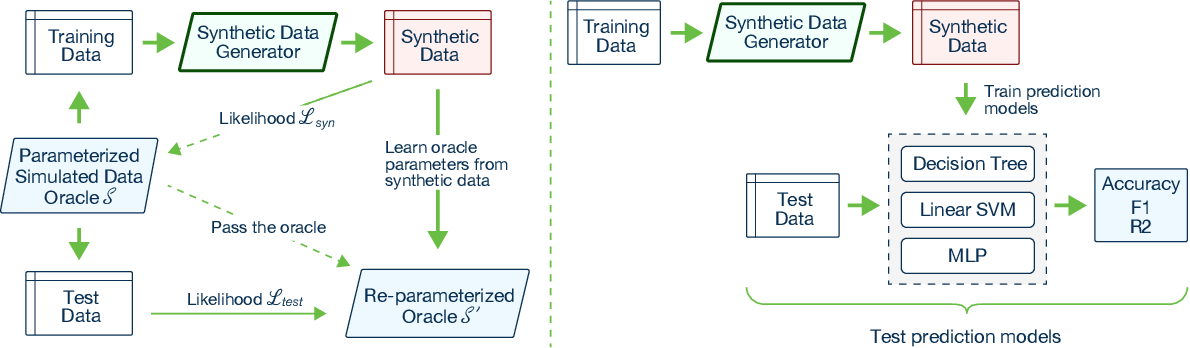

In [ ]:
if copula_gan_synth_model == True: 
  model = CopulaGAN(
    epochs=epochs,
    batch_size=100,
    generator_dim=(256, 256, 256),
    discriminator_dim=(256, 256, 256)
  )

  if training is True:
    model.fit(data)
    model_names.append(model_path+dataset+'_copulagan_'+str(epochs)+'_epochs.pkl')
    model.save(model_names[-1])

#**Model Loading**

In [ ]:
if training is False: 
  model_names.append(model_path+model_to_test)

In [ ]:
model_names

['/content/drive/MyDrive/DL_Models/telephony_copulagan_1000_epochs.pkl']

# **Model Loading and Preparation**

In [ ]:
model_file = []
model_to_load = []
if gaussian_copula_synth_model == True:
  model_file.append(model_names[0])
  model_to_load.append(("GaussianCopula", GaussianCopula))
if ctgan_synth_model == True:
  model_file.append(model_names[-1])
  model_to_load.append(("CTGAN", CTGAN))
elif copula_gan_synth_model == True:
  model_file.append(model_names[-1])
  model_to_load.append(("COPULAGAN", CopulaGAN))

loaded_model = []
for mf,ml in zip(model_file, model_to_load): 
  loaded_model.append((ml[0], ml[1].load(mf)))

AttributeError: ignored

# **Synthetic Data Generation**

In [ ]:
synthetic_data = []
for lm in loaded_model: 
  synthetic_data.append((lm[0], lm[1].sample(n_to_generate)))

# **Synthetic Data Exploratory Analysis**

#**Aggregated Score**

The aggregated score is a value between 0 and 1, and it is an average of all the following metrics

In [ ]:
  scored_and_synth_data = []
  for sd in synthetic_data:
    try:
      print("\nMethod: ",sd[0])
      explore_data(sd[1])
      if save_score is True: 
        score = evaluate(sd[1], data)
        print("\n\nScore: ", score)
      else: 
        score = -1
      scored_and_synth_data.append((sd[0], sd[1], score))  
    except:
      print("Error")


In [ ]:
total_time = timeit.default_timer() - start_global_time

In [ ]:
for sas in scored_and_synth_data:
  sas[1].to_csv(dataset+'_synth_data_generated_by_method_'+sas[0].lower()+'total_time_'+str(round(total_time,2))+'_score_'+str(round(sas[2],3))+'.csv', sep=',')

In [ ]:
for sas in scored_and_synth_data:
  sas[1].to_excel(dataset+'_synth_data_generated_by_method_'+sas[0].lower()+'total_time_'+str(round(total_time,2))+'_score_'+str(round(sas[2],3))+'.xlsx')

In [ ]:
print("Global Exectution Time: ", total_time)